[Spark](http://spark.apache.org) is a general-purpose distributed computing framework, a popular successor in the Big Data world to Hadoop. As of this writing it's in version 2.0.2 with a useful high-level API and growing adoption in many different applications. 


## Spark web User Interface

If you're coming from other types of distributed computing, Spark feels very user-friendly. There is a good-looking UI (in comparison, Hadoop's UI looks like something from 20 years ago) that is spawned automatically each time you launch a Spark job and gives you some critical information about your job *in real-time*. You can see right away, for example, if your parallel workload is poorly balanced by checking the runtime percentiles of the individual tasks that make up an execution stage. 

![Spark stage UI](./spark_ui.png) 

This type of information is great, but running Spark applications involves *many* moving parts: there is the Java JVM, the network and disk I/O, scratch disks, processes distributed over hosts that may be hosting other processes. Seeing some of these runtime statistics in a table makes it difficult to answer questions like "are the slow-running tasks linked to a particular host?" which is what you need to be asking when trying to understand an application's requirements and limitations. 

How many times have I thought something along the lines of "if only I could see a histogram of task runtime by executor!" 

Well, it turns out that all the data is there, you just need to grab it. 

## Spark's secret-not-secret REST API

The same data that is presented in the `SparkContext` web UI is available through a [REST API](http://spark.apache.org/docs/latest/monitoring.html#rest-api). It's a relatively simple matter to start gathering information through this API. 

For a simple demonstration, lets make a plot of mean task execution time per executor, which seems like something we'd want to know if, for example, we suspect that there might be a problem with our distributed filesystem etc. 

The API provides information in an `application/stage/task` hierarchy - we therefore need to drill down all the way to the task-level. To query the REST API we'll use the python `requests` library. We start by extracting the application id

In [3]:
import os
os.environ['http_proxy']=""

In [9]:
import requests
# the base endpoint URL
host = '10.205.19.2'
base_url = 'http://{host}:4040/api/v1'.format(host=host) 

def get_app(base_url):
    response = requests.get(base_url+'/applications')
    return response.json()[0]['id']

In [10]:
get_app(base_url)

u'app-20161209145847-0000'

Using this app ID, we can grab the stages: 

In [14]:
def get_stages(base_url):
    response = requests.get(base_url+'/applications/'+get_app(base_url)+'/stages')
    stages = response.json()
    return [(stage['stageId'], stage['name']) for stage in stages]

In [17]:
for id, stagename in sorted(get_stages(base_url)):
    print id, stagename

0 partitionBy at /cluster/project/sis/ri/roskarr/spark-fof/spark_fof/spark_fof.py:596
1 partitionBy at /cluster/project/sis/ri/roskarr/spark-fof/spark_fof/spark_fof.py:195
2 groupByKey at /cluster/project/sis/ri/roskarr/spark-fof/spark_fof/spark_fof.py:258
3 distinct at /cluster/project/sis/ri/roskarr/spark-fof/spark_fof/spark_fof.py:282
4 runJob at PythonRDD.scala:441


And finally, picking a stage we can grab data about all of its tasks. We'll turn this into a `pandas` `DataFrame` so it will be easier to work with later on. 

In [20]:
import pandas as pd 

def get_tasks(base_url, stageid):
    if isinstance(stageid,int): 
        response = requests.get(base_url+'/applications/'+get_app(base_url)+'/stages/'+str(stageid))
        j = response.json()
        res = [(i,t['host'],t['executorId'],t['taskMetrics']['executorRunTime']) for i,t in j[0]['tasks'].iteritems()]
        columns = ['task_id', 'host_ip', 'executor_id', 'task_time']
        res = pd.DataFrame(res,columns=columns)
    elif isinstance(stageid,list):
        columns = ['task_id', 'host_ip', 'executor_id', 'task_time', 'stageid']
        res = pd.DataFrame(columns=columns)
        for s in stageid: 
            df = get_tasks(s)
            df['stageid'] = s
            res = res.append(df)
    return res

In [24]:
task_df = get_tasks(base_url,1)
task_df.head()

,task_id,host_ip,executor_id,task_time
0,1383,10.205.4.13,9,103431
1,1269,10.205.11.11,44,96142
2,1268,10.205.4.13,58,127085
3,818,10.205.12.55,35,85359
4,819,10.205.11.61,67,116538


Finally, we can create a histogram of time it took for each task to run. In this case, I know that this task is mainly performing I/O from a shared filesystem so it's a good test of whether it's performing as expected. 

In [25]:
%matplotlib inline
import seaborn as sns

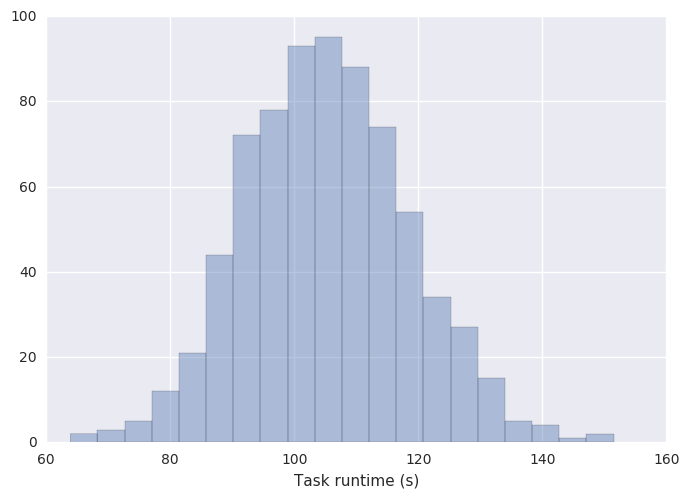

In [26]:
sns.distplot(task_df['task_time']/1000., kde=False, bins=20, axlabel='Task runtime (s)')